In [1]:
from requests import get
from json import loads
from datetime import datetime
import sqlite3
import pandas as pd
import schedule
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
city = ['Warsaw']

def load_forecast():
    wyniki = []
    lat=[]
    lon=[]
    for i in city:
        url = 'http://api.openweathermap.org/geo/1.0/direct?q=' + i +'&limit=1&appid=b04687a69415c03b5ce733e371623723'
        response = get(url)
        #print(loads(response.text))
        for row in loads(response.text):
            if row['country'] == "PL":
                lat=row['lat']
                lon=row['lon']
                #print(lat)
                url2 = 'http://api.openweathermap.org/data/2.5/forecast?lat=' + str(lat) + '&lon=' + str(lon) +'&appid=b04687a69415c03b5ce733e371623723'
                response2 = get(url2)
                #wyniki.append(loads(response2.text))    
                #print(loads(response2.text))
                return loads(response2.text)
    
def load_actual():
    url = 'https://danepubliczne.imgw.pl/api/data/synop'
    response = get(url)
    #print(loads(response.text))
    return loads(response.text)

In [3]:
def create_forecast():
    forecast=[]
    for i in range(len(load_forecast()['list'])):
        dictionary=load_forecast()['list'][i]['main']
        dictionary.update(load_forecast()['list'][i]['clouds'])
        dictionary.update(load_forecast()['list'][i]['wind'])
        try:
            dictionary.update(load_forecast()['list'][i]['rain'])
        except:
            dictionary.update({"3h":0.00})
        dictionary.update({"dt_txt":load_forecast()['list'][i]['dt_txt']})
        forecast.append(dictionary)
        dictionary={}
    return pd.DataFrame.from_dict(forecast)

In [4]:
def roundedtime():
    now=datetime.now()
    time=now.time()
    hour=time.hour
    if hour >= 21:
        r=21
    elif hour >=18:
        r=18
    elif hour>=15:
        r=15
    elif hour >=12:
        r=12
    elif hour>=9:
        r=9
    elif hour >=6:
        r=6
    elif hour>=3:
        r=3
    else:
        r=0
    return datetime(now.year, now.month, now.day, r, 0, 0, 0)

In [5]:
def sql_forecast(table):
    
    conn = sqlite3.connect('D:\sgh\mgr 2\RTA\weather.db')
    curs = conn.cursor()
    try:
        maximum=curs.execute('select max(now) as max from forecast').fetchall()[0][0]
    except:
        maximum=0

    if maximum==table['now'].max():
        print("Forecast - skipped")
    else:
        table.to_sql('forecast',conn, index=False, if_exists='append')
        print("Forecast - updated")

In [6]:
def sql_actual(table):
    
    conn = sqlite3.connect('D:\sgh\mgr 2\RTA\weather.db')
    curs = conn.cursor()
    try:
        maximum=curs.execute('select max(data) as max from actual').fetchall()[0][0]
    except:
        maximum=0
    
    if maximum==table['data'].max():
        print("Actual - skipped")
    else:
        table.to_sql('actual',conn, index=False, if_exists='append')
        print("Actual - updated")

In [7]:
def reload():
    actual_df = pd.DataFrame(load_actual())
    actual_df['godzina_pomiaru'] = actual_df['godzina_pomiaru'].astype(str).str.zfill(2)
    actual_df["data"] = actual_df["data_pomiaru"] + " " + actual_df["godzina_pomiaru"] + ":00:00"
    actual_df=actual_df.drop(["data_pomiaru"],axis=1)
    actual_df=actual_df.drop(["godzina_pomiaru"],axis=1)
    forecast_df=create_forecast()
    forecast_df['now'] = roundedtime().strftime("%Y-%m-%d %H:%M:%S")
    forecast_df['temp']=forecast_df['temp']-273.15
    forecast_df['feels_like']=forecast_df['feels_like']-273.15
    forecast_df['temp_min']=forecast_df['temp_min']-273.15
    forecast_df['temp_max']=forecast_df['temp_max']-273.15
    sql_forecast(forecast_df)
    sql_actual(actual_df)

In [8]:
def read_from_db(table):
    data = sqlite3.connect('D:\sgh\mgr 2\RTA\weather.db')
    query = data.execute(f"SELECT * From {table}")
    cols = [column[0] for column in query.description]
    results= pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return results

In [9]:
def select_diff(hours,table):
    table=table[table['diff']==f'0 days {hours: 2.0f}:00:00']
    return table

In [10]:
def figure(kolumna, tabela, tabela2):
    dictionary={'temp':'temperatura', 'pressure':'cisnienie', 'humidity':'wilgotnosc_wzgledna','3h':'suma_opadu','speed':'predkosc_wiatru'}
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    plt.plot(tabela['dt_txt'],tabela[kolumna])
    plt.plot(tabela2['data'],tabela2[dictionary.get(kolumna,0)])
    plt.xlabel('data', size=15)
    plt.ylabel(kolumna, size=15)
    plt.title(f"Comparison of {kolumna} values actual vs forecast", size=15)
    plt.legend(['forecast','actual'])
    plt.gcf().autofmt_xdate()

In [11]:
def main(diff, parametr):
    reload()
    forecast_db=read_from_db('forecast')
    actual_db=read_from_db('actual')
    actual_db=actual_db[actual_db['stacja']=='Warszawa']
    forecast_db['dt_txt']=pd.to_datetime(forecast_db['dt_txt'], format="%Y-%m-%d %H:%M:%S")
    forecast_db['now']=pd.to_datetime(forecast_db['now'], format="%Y-%m-%d %H:%M:%S")
    forecast_db['diff']=forecast_db['dt_txt']-forecast_db['now']
    forecast_db_filtered=select_diff(diff, forecast_db)
    actual_db['data']=pd.to_datetime(actual_db['data'], format="%Y-%m-%d %H:%M:%S")
    actual_db=actual_db.reset_index()
    actual_db['temperatura']=actual_db['temperatura'].astype(float)
    actual_db['cisnienie']=actual_db['cisnienie'].astype(float)
    actual_db['wilgotnosc_wzgledna']=actual_db['wilgotnosc_wzgledna'].astype(float)
    actual_db['suma_opadu']=actual_db['suma_opadu'].astype(float)
    actual_db['predkosc_wiatru']=actual_db['predkosc_wiatru'].astype(float)
    for p in parametr:
        figure(p, forecast_db_filtered, actual_db)
        plt.show()

Forecast - skipped
Actual - skipped


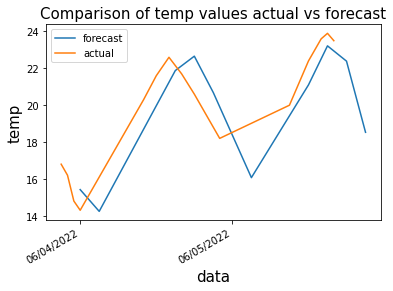

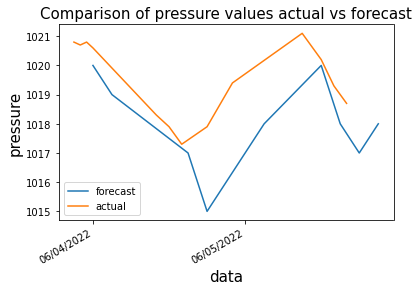

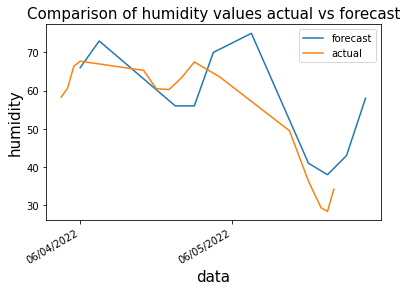

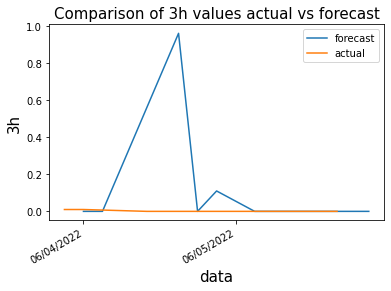

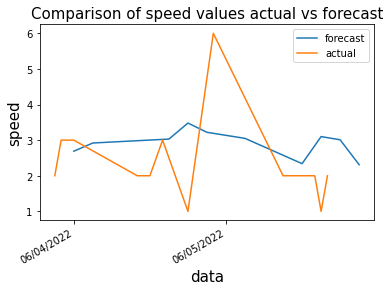

In [12]:
main(3, ['temp', 'pressure', 'humidity','3h','speed'])

In [ ]:
schedule.every(2).hours.do(reload)

while True:
    schedule.run_pending()
    time.sleep(1)